<a href="https://colab.research.google.com/github/rajlm10/D2L-Torch/blob/main/D2L_Pretraining_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contextual Embeddings

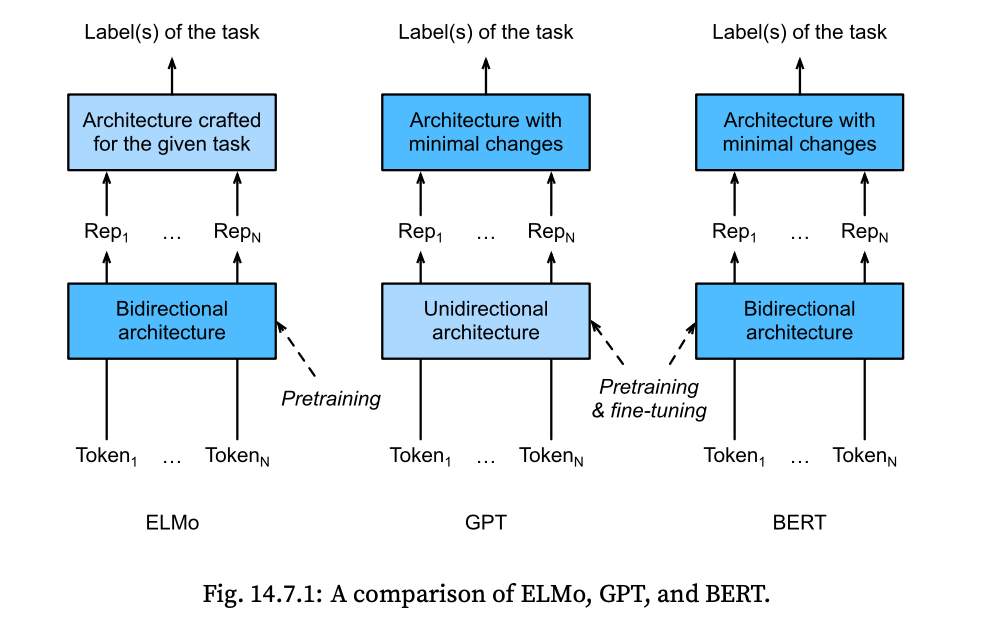

In [ ]:
!pip install d2l -q

In [ ]:
!pip install einops -q

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l
from einops import rearrange,repeat
import os
import nltk
import random
import collections
import multiprocessing
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Representing BERT inputs

In natural language processing, some tasks (e.g., sentiment analysis) take single text as the input, while in some other tasks (e.g., natural language inference), the input is a pair of text sequences.

The BERT input sequence unambiguously represents both single text and text pairs. In the former, the BERT input sequence is the concatenation of the special classification token **cls**, tokens of a text sequence, and the special separation token **sep**. In the latter, the BERT input sequence is the concatenation of **cls**, tokens of the first text sequence, **sep**, tokens of the second text sequence, and **sep**.

To distinguish text pairs, the learned segment embeddings eA and eB are added to the token embeddings of the first sequence and the second sequence, respectively. For single text inputs, only eA is used.

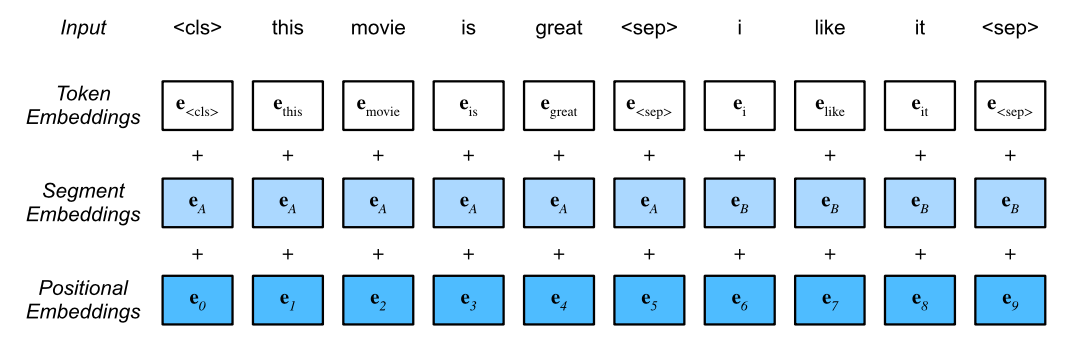

In [ ]:
def get_tokens_and_segments(tokens_a, tokens_b=None):
  """Get tokens of the BERT input sequence and their segment IDs."""
  tokens = ["<cls>"] + tokens_a + ["<sep>"]
  segments = [0] * (len(tokens_a) + 2)
  if tokens_b is not None:
    tokens += tokens_b + ["<sep>"]
    segments += [1] * (len(tokens_b) + 1)
  
  return tokens,segments




# BERT Encoder

In [ ]:
def sequence_mask(X,valid_lens,fill_value=0):
  """Mask irrelevant entries in sequences."""
  #X->batch_size X num_steps
  maxlen=X.size(1)
  mask= torch.arange((maxlen),dtype=torch.float32,device=X.device).repeat(X.shape[0],1)
  mask = mask < valid_lens[:, None]
  return mask.type(torch.int32)[:,None,:]

In [ ]:
class MultiHeadAttention(nn.Module):
  """Multi-head attention."""
  def __init__(self, key_size, query_size, value_size, num_hiddens,num_heads, dropout, bias=False, **kwargs): 
    super(MultiHeadAttention, self).__init__(**kwargs) 
    self.num_heads = num_heads
    self.W_q = nn.Linear(query_size, num_hiddens, bias=bias) 
    self.W_k = nn.Linear(key_size, num_hiddens, bias=bias) 
    self.W_v = nn.Linear(value_size, num_hiddens, bias=bias) 
    self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
    self.dropout=nn.Dropout(dropout)
  
  def forward(self, queries, keys, values, valid_lens):
    queries_copy=queries
    queries = rearrange(self.W_q(queries),'b q (h d_h) -> b h q d_h', h=self.num_heads)
    keys = rearrange(self.W_k(keys),'b k (h d_h) -> b h k d_h', h=self.num_heads)
    values = rearrange(self.W_v(values),'b k (h d_h) -> b h k d_h', h=self.num_heads)
    d = queries.shape[-1]

    attention_weights=torch.einsum('bhqd,bhkd -> bhqk',queries,keys)

    if valid_lens is not None:
      masks= sequence_mask(queries_copy,valid_lens)
      masks = repeat(masks, 'b 1 q -> b h 1 q',h=self.num_heads)
      attention_weights += masks*-1e9
    
    attention_weights = self.dropout(torch.nn.functional.softmax(attention_weights,dim=-1) / (d**0.5))

    
    attention_product = (torch.einsum('bhqk,bhkd -> bhqd',attention_weights,values))

    attention_product = rearrange(attention_product,'b h q d_h -> b q (h d_h)',h=self.num_heads)

    return self.W_o(attention_product)


    

In [ ]:
class PositionWiseFFN(nn.Module):
  """Positionwise feed-forward network."""
  def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,**kwargs):
    super(PositionWiseFFN, self).__init__(**kwargs) 
    self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens) 
    self.relu = nn.ReLU()
    self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

  def forward(self, X):
    return self.dense2(self.relu(self.dense1(X)))

In [ ]:
class AddNorm(nn.Module):
  """Residual connection followed by layer normalization.""" 
  def __init__(self, normalized_shape, dropout, **kwargs):
    super(AddNorm, self).__init__(**kwargs) 
    self.dropout = nn.Dropout(dropout) 
    self.ln = nn.LayerNorm(normalized_shape)

  def forward(self, X, Y):
    return self.ln(self.dropout(Y) + X)

In [ ]:
class EncoderBlock(nn.Module):
  """Transformer encoder block."""
  def __init__(self, key_size, query_size, value_size, num_hiddens,norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,dropout, use_bias=False, **kwargs): 
    super(EncoderBlock, self).__init__(**kwargs)
    #batch_size X no_queries X value_size 
    self.attention = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout,use_bias)
    #norm_shape is [seq_len,num_hiddens] 
    self.addnorm1 = AddNorm(norm_shape, dropout) 
    self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens) 
    self.addnorm2 = AddNorm(norm_shape, dropout)

  def forward(self, X, valid_lens):
    Y = self.addnorm1(X, self.attention(X, X, X, valid_lens)) 
    return self.addnorm2(Y, self.ffn(Y))

In [ ]:
class BERTEncoder(nn.Module):
  def __init__(self,vocab_size,num_hiddens, norm_shape, ffn_num_input,
               ffn_num_hiddens, num_heads, num_layers, dropout, 
               max_len=512, key_size=768, query_size=768, value_size=768, **kwargs):
    super(BERTEncoder, self).__init__(**kwargs) 
    self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
    self.segment_embedding = nn.Embedding (2, num_hiddens)
    self.blks = nn.Sequential()

    for i in range(num_layers):
      self.blks.add_module(f"{i}", EncoderBlock(key_size, query_size, value_size, num_hiddens,
                                                    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, True))
    #Learnable position embeddings
    self.pos_embedding = nn.Parameter(torch.randn(1, max_len,num_hiddens))

  def forward(self,tokens,segments,valid_lens):
    X = self.token_embedding(tokens) + self.segment_embedding(segments) 
    X = X + self.pos_embedding.data[:, :X.shape[1], :]

    for blk in self.blks:
      X= blk(X,valid_lens)
    return X


In [ ]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4 
norm_shape, ffn_num_input, num_layers, dropout = [768], 768, 2, 0.2 
encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape, ffn_num_input,ffn_num_hiddens, num_heads, num_layers, dropout)

In [ ]:
tokens = torch.randint(0, vocab_size, (2, 8))
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]]) 
encoded_X = encoder(tokens, segments, None)
encoded_X.shape

torch.Size([2, 8, 768])

# Pretraining Tasks



## MLM

In this pretraining task, 15% of tokens will be selected at random as the masked tokens for predic- tion. To predict a masked token without cheating by using the label, one straightforward approach is to always replace it with a special **mask** token in the BERT input sequence. However, the artificial special token **mask** will never appear in fine-tuning. To avoid such a mismatch between pretraining and fine-tuning, if a token is masked for prediction (e.g., “great” is selected to be masked and predicted in “this movie is great”), in the input it will be replaced with:

• a special**mask** token for 80% of the time(e.g.,“this movie is great”becomes “this movie is **mask**" 

• a random token for 10% of the time (e.g.,“this movie is great” becomes “this movie is drink”)

• the unchanged label token for 10% of the time (e.g., “this movie is great” becomes “this movie is great”).

The prediction uses a one-hidden-layer MLP (self.mlp). 

In forward inference, it takes two inputs: the encoded result of BERTEncoder and the token positions for prediction. 

The output is the prediction results at these positions.

In [ ]:
batch_idx = torch.arange(0, 2)
num_pred_positions = 3

torch.tensor([[i]* num_pred_positions for i in batch_idx]).reshape(-1)

tensor([0, 0, 0, 1, 1, 1])

In [ ]:
class MaskLM(nn.Module):
  """The masked language model task of BERT."""
  def __init__(self, vocab_size, num_hiddens, num_inputs=768, **kwargs):
    super(MaskLM, self).__init__(**kwargs)
    self.mlp = nn.Sequential(nn.Linear(num_inputs, num_hiddens),
                             nn.ReLU(), nn.LayerNorm(num_hiddens),
                             nn.Linear(num_hiddens, vocab_size))
  
  def forward(self, X, pred_positions):
    # X-> batch,seq_len,hidden_dims
    # pred_positions -> batch X num_pred_positions
    num_pred_positions = pred_positions.shape[1] 
    pred_positions = pred_positions.reshape(-1) 
    batch_size = X.shape[0]
    batch_idx = torch.arange(0, batch_size)
    batch_idx = torch.tensor([[i]* num_pred_positions for i in batch_idx]).reshape(-1)
    #batch_idx-> (batch_size * num_pred_positions,)
    # Represents how many samples to choose

    masked_X = X[batch_idx, pred_positions]
    #masked_X -> (batch_size * num_pred_positions, hidden_dims)
    #masked_X contains the representations of all masked tokens
    masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
    mlm_Y_hat = self.mlp(masked_X)
    
    return mlm_Y_hat #batch_size,num_pred_positions,vocab_size


In [ ]:
mlm = MaskLM(vocab_size, num_hiddens)

mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]]) 
mlm_Y_hat = mlm(encoded_X, mlm_positions) 
mlm_Y_hat.shape

torch.Size([2, 3, 10000])

In [ ]:
mlm_Y = torch.tensor([[7, 8, 9], [10, 20, 30]])
loss = nn.CrossEntropyLoss(reduction='none')
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1)) 
mlm_l.shape # (batch_size*num_pred_positions,)

torch.Size([6])

##Next Sentence Prediction

To help understand the relationship between two text sequences, BERT considers a binary classification task, next sentence prediction, in its pretraining. When generating sentence pairs for pretraining, for half of the time they are indeed consecutive sentences with the label “True”; while for the other half of the time the second sentence is randomly sampled from the corpus with the label “False”

Due to self-attention in the transformer encoder, the BERT representation of the special token **cls** encodes both the two sentences from the input. Hence, the output layer (self.output) of the MLP classifier takes X as the input, where X is the output of the MLP hidden layer whose input is the encoded **cls** token

In [ ]:
class NextSentencePred(nn.Module):
  def __init__(self, num_inputs, **kwargs): 
    super(NextSentencePred, self).__init__(**kwargs) 
    self.output = nn.Linear(num_inputs, 2)
  
  def forward(self, X):
    # `X` shape: (batch size, `num_hiddens`) 
    return self.output(X)

nsp = NextSentencePred(encoded_X.shape[-1])
nsp_Y_hat = nsp(encoded_X[:,0,:])
nsp_Y_hat.shape

torch.Size([2, 2])

In [ ]:
nsp_y = torch.tensor([0, 1]) 
nsp_l = loss(nsp_Y_hat, nsp_y) 
nsp_l.shape #batch_size

torch.Size([2])

# BERT Model (includes MLM and NSP)

In [ ]:
class BERTModel(nn.Module):
  """The BERT model."""
  def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
               ffn_num_hiddens, num_heads, num_layers, dropout, 
               max_len=512, key_size=768, query_size=768, value_size=768,
               hid_in_features=768, mlm_in_features=768,nsp_in_features=768):
    super(BERTModel, self).__init__()
    self.encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape,
                               ffn_num_input, ffn_num_hiddens,
                               num_heads, num_layers, dropout, max_len=max_len,
                               key_size=key_size, query_size=query_size, value_size=value_size)
    
    self.hidden = nn.Sequential(nn.Linear(hid_in_features, num_hiddens), nn.Tanh())
    self.mlm = MaskLM(vocab_size, num_hiddens, mlm_in_features) 
    self.nsp = NextSentencePred(nsp_in_features)
  
  def forward(self, tokens, segments, valid_lens=None, pred_positions=None): 
    encoded_X = self.encoder(tokens, segments, valid_lens)
    if pred_positions is not None:
      mlm_Y_hat = self.mlm(encoded_X, pred_positions) 
    else:
      mlm_Y_hat = None
    nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))

    #encoded_X -> batch_size,max_len,num_hiddens
    #mlm_Y_hat -> batch_size, len(pred_positions), vocab_size
    # nsp_Y_hat -> batch_size,
    return encoded_X, mlm_Y_hat, nsp_Y_hat

# The Dataset

In the WikiText-2 dataset, each line represents a paragraph where space is inserted between any punctuation and its preceding token. Paragraphs with at least two sentences are retained. To split sentences, we only use the period as the delimiter for simplicity. We leave discussions of more complex sentence splitting techniques in the exercises at the end of this section.

In [ ]:
d2l.DATA_HUB['wikitext-2'] = ( 'https://s3.amazonaws.com/research.metamind.io/wikitext/' 'wikitext-2-v1.zip', '3c914d17d80b1459be871a5039ac23e752a53cbe')

In [ ]:
def _read_wiki(data_dir):
  file_name = os.path.join(data_dir, 'wiki.train.tokens') 
  with open(file_name, 'r') as f:
    lines = f.readlines()
  # Uppercase letters are converted to lowercase ones 
  paragraphs = [nltk.tokenize.sent_tokenize(line.strip().lower()) for line in lines if len(nltk.tokenize.sent_tokenize(line)) >= 2]
  random.shuffle(paragraphs)
  return paragraphs

In [ ]:
def _get_next_sentence(sentence, next_sentence, paragraphs): 
  if random.random() < 0.5:
    is_next = True 
  else:
    # `paragraphs` is a list of lists of lists
    next_sentence = random.choice(random.choice(paragraphs))
    is_next = False
  return sentence, next_sentence, is_next

The following function generates training examples for next sentence prediction from the input paragraph by invoking the _get_next_sentence function.

**Here paragraph is a list of sentences, where each sentence is a list of tokens. Hence paragraphs is a list of paragraph** The argument max_len specifies the maximum length of a BERT input sequence during pretraining.

In [ ]:
def _get_nsp_data_from_paragraph(paragraph, paragraphs, max_len): 
  nsp_data_from_paragraph = []
  for i in range(len(paragraph) - 1):
    tokens_a, tokens_b, is_next = _get_next_sentence( paragraph[i], paragraph[i + 1], paragraphs)
    # Consider 1 '<cls>' token and 2 '<sep>' tokens 
    if len(tokens_a) + len(tokens_b) + 3 > max_len:
      continue
    tokens, segments = get_tokens_and_segments(tokens_a, tokens_b)
    nsp_data_from_paragraph.append((tokens, segments, is_next)) 
  return nsp_data_from_paragraph

In its inputs, tokens is a list of tokens representing a BERT input sequence, candidate_pred_positions is a list of token indices of the BERT input sequence **excluding those of special tokens (special tokens are not predicted in the masked language modeling task)**, and num_mlm_preds indicates the number of predictions (recall 15% random tokens to predict). 

Following the definition of the masked language modeling task, at each prediction position, the input may be replaced by a special < mask > token or a random token, or remain unchanged. 

**In the end, the function returns the input tokens after possible replacement, the token indices where predictions take place and labels for these predictions.**

In [ ]:
def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds, vocab):
  # Make a new copy of tokens for the input of a masked language model, 
  # where the input may contain replaced '<mask>' or random tokens 
  mlm_input_tokens = [token for token in tokens] 
  pred_positions_and_labels = []
  # Shuffle for getting 15% random tokens for prediction in the mlm task
  for mlm_pred_position in candidate_pred_positions:
    if len(pred_positions_and_labels) >= num_mlm_preds: 
      break
    masked_token = None
    # 80% of the time: replace the word with the '<mask>' token 
    if random.random() < 0.8:
      masked_token = '<mask>'
    
    else:
      # 10% of the time: keep the word unchanged
      if random.random() < 0.5:
        masked_token = tokens[mlm_pred_position]
      # 10% of the time: replace the word with a random word
      else:
        masked_token = random.choice(vocab.idx_to_token)
    mlm_input_tokens[mlm_pred_position] = masked_token 
    
    pred_positions_and_labels.append((mlm_pred_position, tokens[mlm_pred_position]))
  
  return mlm_input_tokens, pred_positions_and_labels


By invoking the aforementioned _replace_mlm_tokens function, the following function takes a BERT input sequence (tokens) as an input and returns indices of the input tokens (after possible token replacement) the token indices where predictions take place, and label indices for these predictions.

In [ ]:
def _get_mlm_data_from_tokens(tokens, vocab): 
  candidate_pred_positions = []
  # `tokens` is a list of strings
  for i, token in enumerate(tokens):
    # Special tokens are not predicted in mlm
    if token in ['<cls>', '<sep>']:
        continue
    candidate_pred_positions.append(i)
  # 15% of total tokens are masked in mlm
  num_mlm_preds = max(1, round(len(tokens) * 0.15))
  
  mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(tokens, 
                                                                    candidate_pred_positions, 
                                                                    num_mlm_preds, 
                                                                    vocab)
  #sort by position
  pred_positions_and_labels = sorted(pred_positions_and_labels,key=lambda x: x[0])
  pred_positions = [v[0] for v in pred_positions_and_labels]
  mlm_pred_labels = [v[1] for v in pred_positions_and_labels]

  #return vocab indices for masked inputs
  # positions in tokens list where masking/replacement has occured
  # vocab indices for original tokens which were masked/replaced
  return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]


Now we are almost ready to customize a Dataset class for pretraining BERT. Before that, we still need to define a helper function _pad_bert_inputs to append the special < mask > tokens to the inputs. 

Its argument examples contain the outputs from the helper functions _get_nsp_data_from_paragraph and _get_mlm_data_from_tokens for the two pretraining tasks.

In [ ]:
def _pad_bert_inputs(examples, max_len, vocab):
  max_num_mlm_preds = round(max_len * 0.15)
  all_token_ids, all_segments, valid_lens, = [], [], [] 
  all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], [] 
  nsp_labels = []

  for (token_ids, pred_positions, mlm_pred_label_ids, segments, is_next) in examples:
    all_token_ids.append(torch.tensor(token_ids + [vocab['<pad>']] * ( max_len - len(token_ids)), dtype=torch.long))
    all_segments.append(torch.tensor(segments + [0] * ( max_len - len(segments)), dtype=torch.long))
    valid_lens.append(torch.tensor(len(token_ids), dtype=torch.float32))
    
    all_pred_positions.append(torch.tensor(pred_positions + [0] * (max_num_mlm_preds - len(pred_positions)), dtype=torch.long))
    # Predictions of padded tokens will be filtered out in the loss via multiplication of 0 weights
    all_mlm_weights.append(torch.tensor([1.0] * len(mlm_pred_label_ids) 
                                      + [0.0] * ( max_num_mlm_preds - len(pred_positions)), dtype=torch.float32))
    
    all_mlm_labels.append(torch.tensor(mlm_pred_label_ids + [0] * ( max_num_mlm_preds - len(mlm_pred_label_ids)), dtype=torch.long))
    
    nsp_labels.append(torch.tensor(is_next, dtype=torch.long)) 
    
  return (all_token_ids, all_segments, valid_lens, all_pred_positions, all_mlm_weights, all_mlm_labels, nsp_labels)


**The original BERT model uses WordPiece embeddings whose vocabulary size is 30000 (Wu et al., 2016). For simplicity, we use the d2l.tokenize function for tokenization. Infrequent tokens that appear less than five times are filtered out.**

In [ ]:
def tokenize(lines,token='word'):
  if token=='word':
    return [line.split() for line in lines]
  if token=='char':
    return [list(line) for line in lines]
  else:
    print('ERROR: unknown token type: ' + token)

In [ ]:
class Vocab:
  def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
    if tokens is None:
      tokens = []
    if reserved_tokens is None: 
      reserved_tokens = []
    # Sort according to frequencies
    counter = count_corpus(tokens)
    self._token_freqs = sorted(counter.items(), key=lambda x: x[1],reverse=True)

    #Build vocab on init
    self.idx_to_token=['<unk>']+reserved_tokens #List
    self.token_to_idx={token:idx for idx,token in enumerate(self.idx_to_token)} #Dict

    for token,freq in self._token_freqs:
      #Don't include tokens with freq<min_freq in the vocab
      if freq<min_freq:
        break
      if token not in self.idx_to_token:
        self.idx_to_token.append(token)
        self.token_to_idx[token]=len(self.idx_to_token)-1

  def __len__(self):
    return len(self.idx_to_token)

  @property
  def unk(self):
    # Index for the unknown token
    return 0
  
  @property
  def token_freqs(self):
    # Counter object 
    return self._token_freqs
  
  def __getitem__(self,tokens):
    if not isinstance(tokens, (list, tuple)):
      return self.token_to_idx.get(tokens, self.unk) 
    #If tokens is a list 
    return [self.__getitem__(token) for token in tokens]

  def to_tokens(self, indices):
    if not isinstance(indices, (list, tuple)):
      return self.idx_to_token[indices]
    #If indices is a list
    return [self.idx_to_token[index] for index in indices]


def count_corpus(tokens):
  """Count token frequencies."""
  # Here `tokens` is a 1D list or 2D list
  if len(tokens) == 0 or isinstance(tokens[0], list):
    # Flatten a list of token lists into a 1D list
    tokens = [token for line in tokens for token in line]
  #If its already a 1D list,return  
  return collections.Counter(tokens)

In [ ]:
class _WikiTextDataset(torch.utils.data.Dataset): 
    # Input `paragraphs[i]` is a list of sentence strings representing a 
    # paragraph; while output `paragraphs[i]` is a list of sentences
    # representing a paragraph, where each sentence is a list of tokens
  def __init__(self, paragraphs, max_len):
    paragraphs = [tokenize(paragraph, token='word') for paragraph in paragraphs]
    sentences = [sentence for paragraph in paragraphs for sentence in paragraph]
    self.vocab = Vocab(sentences, min_freq=5, reserved_tokens=['<pad>', '<mask>', '<cls>', '<sep>'])
    # Get data for the next sentence prediction task
    examples = []
    
    for paragraph in paragraphs:
      examples.extend(_get_nsp_data_from_paragraph( paragraph, paragraphs, max_len))
    
    # Get data for the masked language model task
    examples = [(_get_mlm_data_from_tokens(tokens, self.vocab) + (segments, is_next)) 
                for tokens, segments, is_next in examples]

    (self.all_token_ids, self.all_segments, self.valid_lens, self.all_pred_positions, 
     self.all_mlm_weights, self.all_mlm_labels, 
     self.nsp_labels) = _pad_bert_inputs(examples, max_len, self.vocab)
    
  def __getitem__(self, idx):
    return (self.all_token_ids[idx], self.all_segments[idx],
            self.valid_lens[idx], self.all_pred_positions[idx], 
            self.all_mlm_weights[idx], self.all_mlm_labels[idx], self.nsp_labels[idx])
  
  def __len__(self):
    return len(self.all_token_ids)





In [ ]:
def load_data_wiki(batch_size, max_len):
  """Load the WikiText-2 dataset."""
  num_workers = multiprocessing.cpu_count()
  data_dir = d2l.download_extract('wikitext-2', 'wikitext-2') 
  paragraphs = _read_wiki(data_dir)
  train_set = _WikiTextDataset(paragraphs, max_len)
  train_iter = torch.utils.data.DataLoader(train_set, batch_size,shuffle=True, num_workers=num_workers)
  return train_iter, train_set.vocab

In [ ]:
batch_size, max_len = 128, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)



In [ ]:
for (tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y) in train_iter:
  print(f'tokens_X.shape: {tokens_X.shape}, segments_X.shape: {segments_X.shape}\n valid_lens_x.shape: {valid_lens_x.shape}, pred_positions_X.shape: {pred_positions_X.shape}\n mlm_weights_X.shape: {mlm_weights_X.shape}, mlm_Y.shape: {mlm_Y.shape}, nsp_y.shape: {nsp_y.shape}')
  break

tokens_X.shape: torch.Size([128, 64]), segments_X.shape: torch.Size([128, 64])
 valid_lens_x.shape: torch.Size([128]), pred_positions_X.shape: torch.Size([128, 10])
 mlm_weights_X.shape: torch.Size([128, 10]), mlm_Y.shape: torch.Size([128, 10]), nsp_y.shape: torch.Size([128])


In [ ]:
len(vocab)

20070

# Pretraining BERT



The original BERT has two versions of different model sizes (Devlin et al., 2018). The base model (BERT BASE) uses 12 layers (transformer encoder blocks) with 768 hidden units (hidden size) and 12 self-attention heads. The large model (BERT LARGE) uses 24 layers with 1024 hidden units and 16 self-attention heads. Notably, the former has 110 million parameters while the latter has 340 million parameters. 

For demonstration with ease,  define a small BERT, using 2 layers, 128 hidden units, and 2 self-attention heads.

**Since I have access to a powerful GPU, I will use 12 layers, 768 dims and a 12 attention heads**

In [ ]:
net = BERTModel(len(vocab), num_hiddens=768, norm_shape=[768], ffn_num_input=768, ffn_num_hiddens=4*768, num_heads=12,num_layers=12, dropout=0.2, key_size=768, query_size=768, value_size=768, hid_in_features=768, mlm_in_features=768, nsp_in_features=768)
devices = d2l.try_all_gpus()
print(devices) 
loss = nn.CrossEntropyLoss(reduction='none')

[device(type='cuda', index=0)]


In [ ]:
!nvidia-smi

Mon Jun 20 08:25:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#courtesy Thong Ngyuen 
#https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(net)

+--------------------------------------+------------+
|               Modules                | Parameters |
+--------------------------------------+------------+
|        encoder.pos_embedding         |   393216   |
|    encoder.token_embedding.weight    |  15413760  |
|   encoder.segment_embedding.weight   |    1536    |
| encoder.blks.0.attention.W_q.weight  |   589824   |
|  encoder.blks.0.attention.W_q.bias   |    768     |
| encoder.blks.0.attention.W_k.weight  |   589824   |
|  encoder.blks.0.attention.W_k.bias   |    768     |
| encoder.blks.0.attention.W_v.weight  |   589824   |
|  encoder.blks.0.attention.W_v.bias   |    768     |
| encoder.blks.0.attention.W_o.weight  |   589824   |
|  encoder.blks.0.attention.W_o.bias   |    768     |
|  encoder.blks.0.addnorm1.ln.weight   |    768     |
|   encoder.blks.0.addnorm1.ln.bias    |    768     |
|   encoder.blks.0.ffn.dense1.weight   |  2359296   |
|    encoder.blks.0.ffn.dense1.bias    |    3072    |
|   encoder.blks.0.ffn.dense

117481064

In [ ]:
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,pred_positions_X, mlm_weights_X, mlm_Y, nsp_y):
    # Forward pass
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X, valid_lens_x.reshape(-1),pred_positions_X)
    # Compute masked language model loss
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) * mlm_weights_X.reshape(-1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8) 
    # Compute next sentence prediction loss
    nsp_l = loss(nsp_Y_hat, nsp_y)
    nsp_l = nsp_l.mean() 
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

In [ ]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps): 
  net = nn.DataParallel(net, device_ids=devices).to(devices[0]) 
  trainer = torch.optim.Adam(net.parameters(), lr=0.01)
  step, timer = 0, d2l.Timer()
  # Sum of masked language modeling losses, sum of next sentence prediction 
  # losses, no. of sentence pairs, count
  metric = d2l.Accumulator(4)
  num_steps_reached = False
  while step < num_steps and not num_steps_reached:
    for tokens_X, segments_X, valid_lens_x, pred_positions_X,mlm_weights_X, mlm_Y, nsp_y in train_iter:
      tokens_X = tokens_X.to(devices[0])
      segments_X = segments_X.to(devices[0])
      valid_lens_x = valid_lens_x.to(devices[0]) 
      pred_positions_X = pred_positions_X.to(devices[0]) 
      mlm_weights_X = mlm_weights_X.to(devices[0])
      mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
      trainer.zero_grad()
      timer.start()
      mlm_l, nsp_l, l = _get_batch_loss_bert(net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                                             pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
      l.backward()
      trainer.step()
      metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1) 
      timer.stop()

      step += 1
      if step == num_steps:
        num_steps_reached = True 
        break
      
      if step%100==0:
        print(f'Step: {step}: MLM loss {metric[0] / metric[3]:.3f}, ' f'NSP loss {metric[1] / metric[3]:.3f}')
  print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on ' f'{str(devices)}')


In [ ]:
torch.cuda.empty_cache()  # clear GPU


In [ ]:
!nvidia-smi

Mon Jun 20 08:25:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
train_bert(train_iter, net, loss, len(vocab), devices, 10000)

Step: 100: MLM loss 8.096, NSP loss 0.942
Step: 200: MLM loss 7.547, NSP loss 0.845
Step: 300: MLM loss 7.349, NSP loss 0.817
Step: 400: MLM loss 7.235, NSP loss 0.813
Step: 500: MLM loss 7.168, NSP loss 0.802
Step: 600: MLM loss 7.124, NSP loss 0.795
Step: 700: MLM loss 7.089, NSP loss 0.798
Step: 800: MLM loss 7.062, NSP loss 0.792
Step: 900: MLM loss 7.045, NSP loss 0.792
Step: 1000: MLM loss 7.028, NSP loss 0.793
Step: 1100: MLM loss 7.014, NSP loss 0.792
Step: 1200: MLM loss 7.003, NSP loss 0.788
Step: 1300: MLM loss 6.994, NSP loss 0.786
Step: 1400: MLM loss 6.984, NSP loss 0.786
Step: 1500: MLM loss 6.977, NSP loss 0.785
Step: 1600: MLM loss 6.971, NSP loss 0.785
Step: 1700: MLM loss 6.963, NSP loss 0.784
Step: 1800: MLM loss 6.958, NSP loss 0.789
Step: 1900: MLM loss 6.954, NSP loss 0.786
Step: 2000: MLM loss 6.950, NSP loss 0.787
Step: 2100: MLM loss 6.946, NSP loss 0.786
Step: 2200: MLM loss 6.943, NSP loss 0.785
Step: 2300: MLM loss 6.939, NSP loss 0.786
Step: 2400: MLM loss

#Representing Text with BERT

In [ ]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
  tokens, segments = get_tokens_and_segments(tokens_a, tokens_b) 
  token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0) 
  segments = torch.tensor(segments, device=devices[0]).unsqueeze(0) 
  valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0) 
  encoded_X, _, _ = net(token_ids, segments, valid_len)
  return encoded_X

In [ ]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane_a = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane_a.shape

(torch.Size([1, 6, 768]), torch.Size([1, 768]), torch.Size([1, 768]))

In [ ]:
encoded_text_crane_a

tensor([[-7.9110e-01, -2.0810e+00, -6.7607e-01,  3.3764e-02, -2.0124e+00,
         -2.7881e-01, -1.9047e+00,  1.2530e+00,  2.3843e-03, -2.4814e+00,
         -1.0559e-01, -6.2342e-02,  1.8325e-01, -1.6490e+00,  2.4248e-01,
          2.4954e-01,  2.5955e-02,  8.2801e-01, -2.8848e+00,  4.5906e-01,
          2.7566e-01,  6.2832e-03,  2.3019e-01,  2.7803e+00, -7.0909e-01,
          5.1764e-01, -2.5264e-01,  3.7325e-02, -9.5786e-02,  3.3352e-03,
          2.1541e-01, -2.4520e-01,  2.8496e-01,  2.3772e-03, -2.7555e+00,
          2.5177e+00,  1.7858e+00,  5.8822e-01, -4.0614e-02, -7.7985e-02,
          5.6167e-01,  1.1350e+00, -5.7625e-01, -1.4612e+00, -7.9794e-02,
         -8.7225e-01,  2.2297e+00, -2.1976e-02, -6.1777e-01,  5.8618e-01,
          1.6389e+00,  8.9458e-01, -2.5015e+00, -9.1029e-02,  1.7724e-02,
         -3.5625e-02,  1.1510e+00,  1.3824e-01, -6.1386e-01,  2.3677e+00,
         -9.5740e-02, -1.7609e+00,  5.5819e-01,  7.9871e-01, -3.5268e-02,
         -5.3308e-02, -3.9794e-02,  2.

In [ ]:
tokens_b = ['a', 'crane', 'driver', 'came']
encoded_pair = get_bert_encoding(net, tokens_b)

encoded_pair_cls = encoded_pair[:, 0, :]
encoded_text_crane_b = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_text_crane_b.shape

(torch.Size([1, 6, 768]), torch.Size([1, 768]), torch.Size([1, 768]))

In [ ]:
encoded_text_crane_b

tensor([[-8.0255e-01, -2.1095e+00, -6.8357e-01,  1.7569e-01, -2.0422e+00,
         -6.7978e-02, -1.9328e+00,  1.2633e+00,  9.6245e-04, -2.5168e+00,
         -1.0963e-01, -2.1943e-01,  1.8420e-01, -1.6732e+00,  8.5421e-01,
          2.5206e-01,  2.8207e-01,  8.3717e-01, -2.9222e+00,  1.6125e+00,
          1.5944e+00, -3.5992e-02,  2.3232e-01,  4.1054e-01, -7.2027e-01,
          5.2424e-01,  4.7660e-02,  3.4892e-02, -9.8526e-02,  2.0048e-04,
          2.1563e-01, -2.4689e-01,  2.8802e-01, -3.4593e-02, -2.7887e+00,
          4.0977e-01,  1.8057e+00,  5.9324e-01, -4.2108e-02, -1.6934e-01,
          5.6892e-01,  2.9715e-01, -5.8550e-01, -1.4821e+00, -8.2584e-02,
         -8.8656e-01,  2.2565e+00,  2.1235e-02, -6.2500e-01,  5.9155e-01,
          1.6575e+00,  9.0431e-01, -2.5359e+00, -9.4486e-02,  4.3127e-01,
         -3.9016e-02,  1.1602e+00,  1.3946e-01, -6.2263e-01,  2.3920e+00,
         -9.8719e-02, -1.7821e+00,  5.6369e-01,  8.0685e-01,  5.4071e-03,
          6.0654e-03, -4.1503e-02,  2.

In [ ]:
torch.cosine_similarity(encoded_text_crane_a,encoded_text_crane_b)

tensor([0.8854], device='cuda:0', grad_fn=<DivBackward0>)

**Note that the elements of the polysemy token “crane” are different from those when the context is different. This supports that BERT representations are context-sensitive.**